## Question:

### Let’s say we want to build a model to predict booking prices on Airbnb. Between linear regression and random forest regression, which model would perform better and why?

## Answer:

### Importing librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
import plotly.express as px
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
import warnings
warnings.filterwarnings('ignore')
# to ignore not important warning

### Uploading dataset

In [5]:
data = pd.read_csv("C://Users/hp/Downloads/AirBNB.csv")
data.head()

,id,room_type,accommodates,bathrooms,cancellation_policy,cleaning_fee,instant_bookable,review_scores_rating,bedrooms,beds,log_price
0,6901257,Entire home/apt,3.000,1.000,strict,True,f,100.000,1.000,1.000,5.011
1,6304928,Entire home/apt,7.000,1.000,strict,True,t,93.000,3.000,3.000,5.130
2,7919400,Entire home/apt,5.000,1.000,moderate,True,t,92.000,1.000,3.000,4.977
3,13418779,Entire home/apt,4.000,1.000,flexible,True,f,NaN,2.000,2.000,6.620
4,3808709,Entire home/apt,2.000,1.000,moderate,True,t,40.000,0.000,1.000,4.745


In [6]:
data.describe()

,id,accommodates,bathrooms,review_scores_rating,bedrooms,beds,log_price
count,74111.000,74108.000,73908.000,57389.000,74019.000,73980.000,74111.000
mean,11266617.102,3.155,1.235,94.067,1.266,1.711,4.782
std,6081734.887,2.154,0.582,7.837,0.852,1.254,0.717
min,344.000,1.000,0.000,20.000,0.000,0.000,0.000
25%,6261964.500,2.000,1.000,92.000,1.000,1.000,4.317
50%,12254147.000,2.000,1.000,96.000,1.000,1.000,4.710
75%,16402260.500,4.000,1.000,100.000,1.000,2.000,5.220
max,21230903.000,16.000,8.000,100.000,10.000,18.000,7.600


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    74111 non-null  int64  
 1   room_type             74106 non-null  object 
 2   accommodates          74108 non-null  float64
 3   bathrooms             73908 non-null  float64
 4   cancellation_policy   74103 non-null  object 
 5   cleaning_fee          74107 non-null  object 
 6   instant_bookable      74111 non-null  object 
 7   review_scores_rating  57389 non-null  float64
 8   bedrooms              74019 non-null  float64
 9   beds                  73980 non-null  float64
 10  log_price             74111 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 6.2+ MB


### Now we can reorganise data with only needed columns

In [8]:
data = data.drop(['id'], axis=1)

In [9]:
data.describe()

,accommodates,bathrooms,review_scores_rating,bedrooms,beds,log_price
count,74108.000,73908.000,57389.000,74019.000,73980.000,74111.000
mean,3.155,1.235,94.067,1.266,1.711,4.782
std,2.154,0.582,7.837,0.852,1.254,0.717
min,1.000,0.000,20.000,0.000,0.000,0.000
25%,2.000,1.000,92.000,1.000,1.000,4.317
50%,2.000,1.000,96.000,1.000,1.000,4.710
75%,4.000,1.000,100.000,1.000,2.000,5.220
max,16.000,8.000,100.000,10.000,18.000,7.600


### We want to see what are unique value for any variable

In [10]:
for col in data.select_dtypes(include=['object']):
    data[col] = data[col].astype('category')
    
cat_col = data.select_dtypes(include=['category'])

for col in cat_col:
    print('Unique Values of {} are \n'.format(col),data[col].unique())
    print('='*50)

Unique Values of room_type are 
 ['Entire home/apt', 'Private room', 'Shared room', NaN]
Categories (3, object): ['Entire home/apt', 'Private room', 'Shared room']
Unique Values of cancellation_policy are 
 ['strict', 'moderate', 'flexible', NaN]
Categories (3, object): ['flexible', 'moderate', 'strict']
Unique Values of cleaning_fee are 
 [True, False, NaN]
Categories (2, bool): [False, True]
Unique Values of instant_bookable are 
 ['f', 't']
Categories (2, object): ['f', 't']


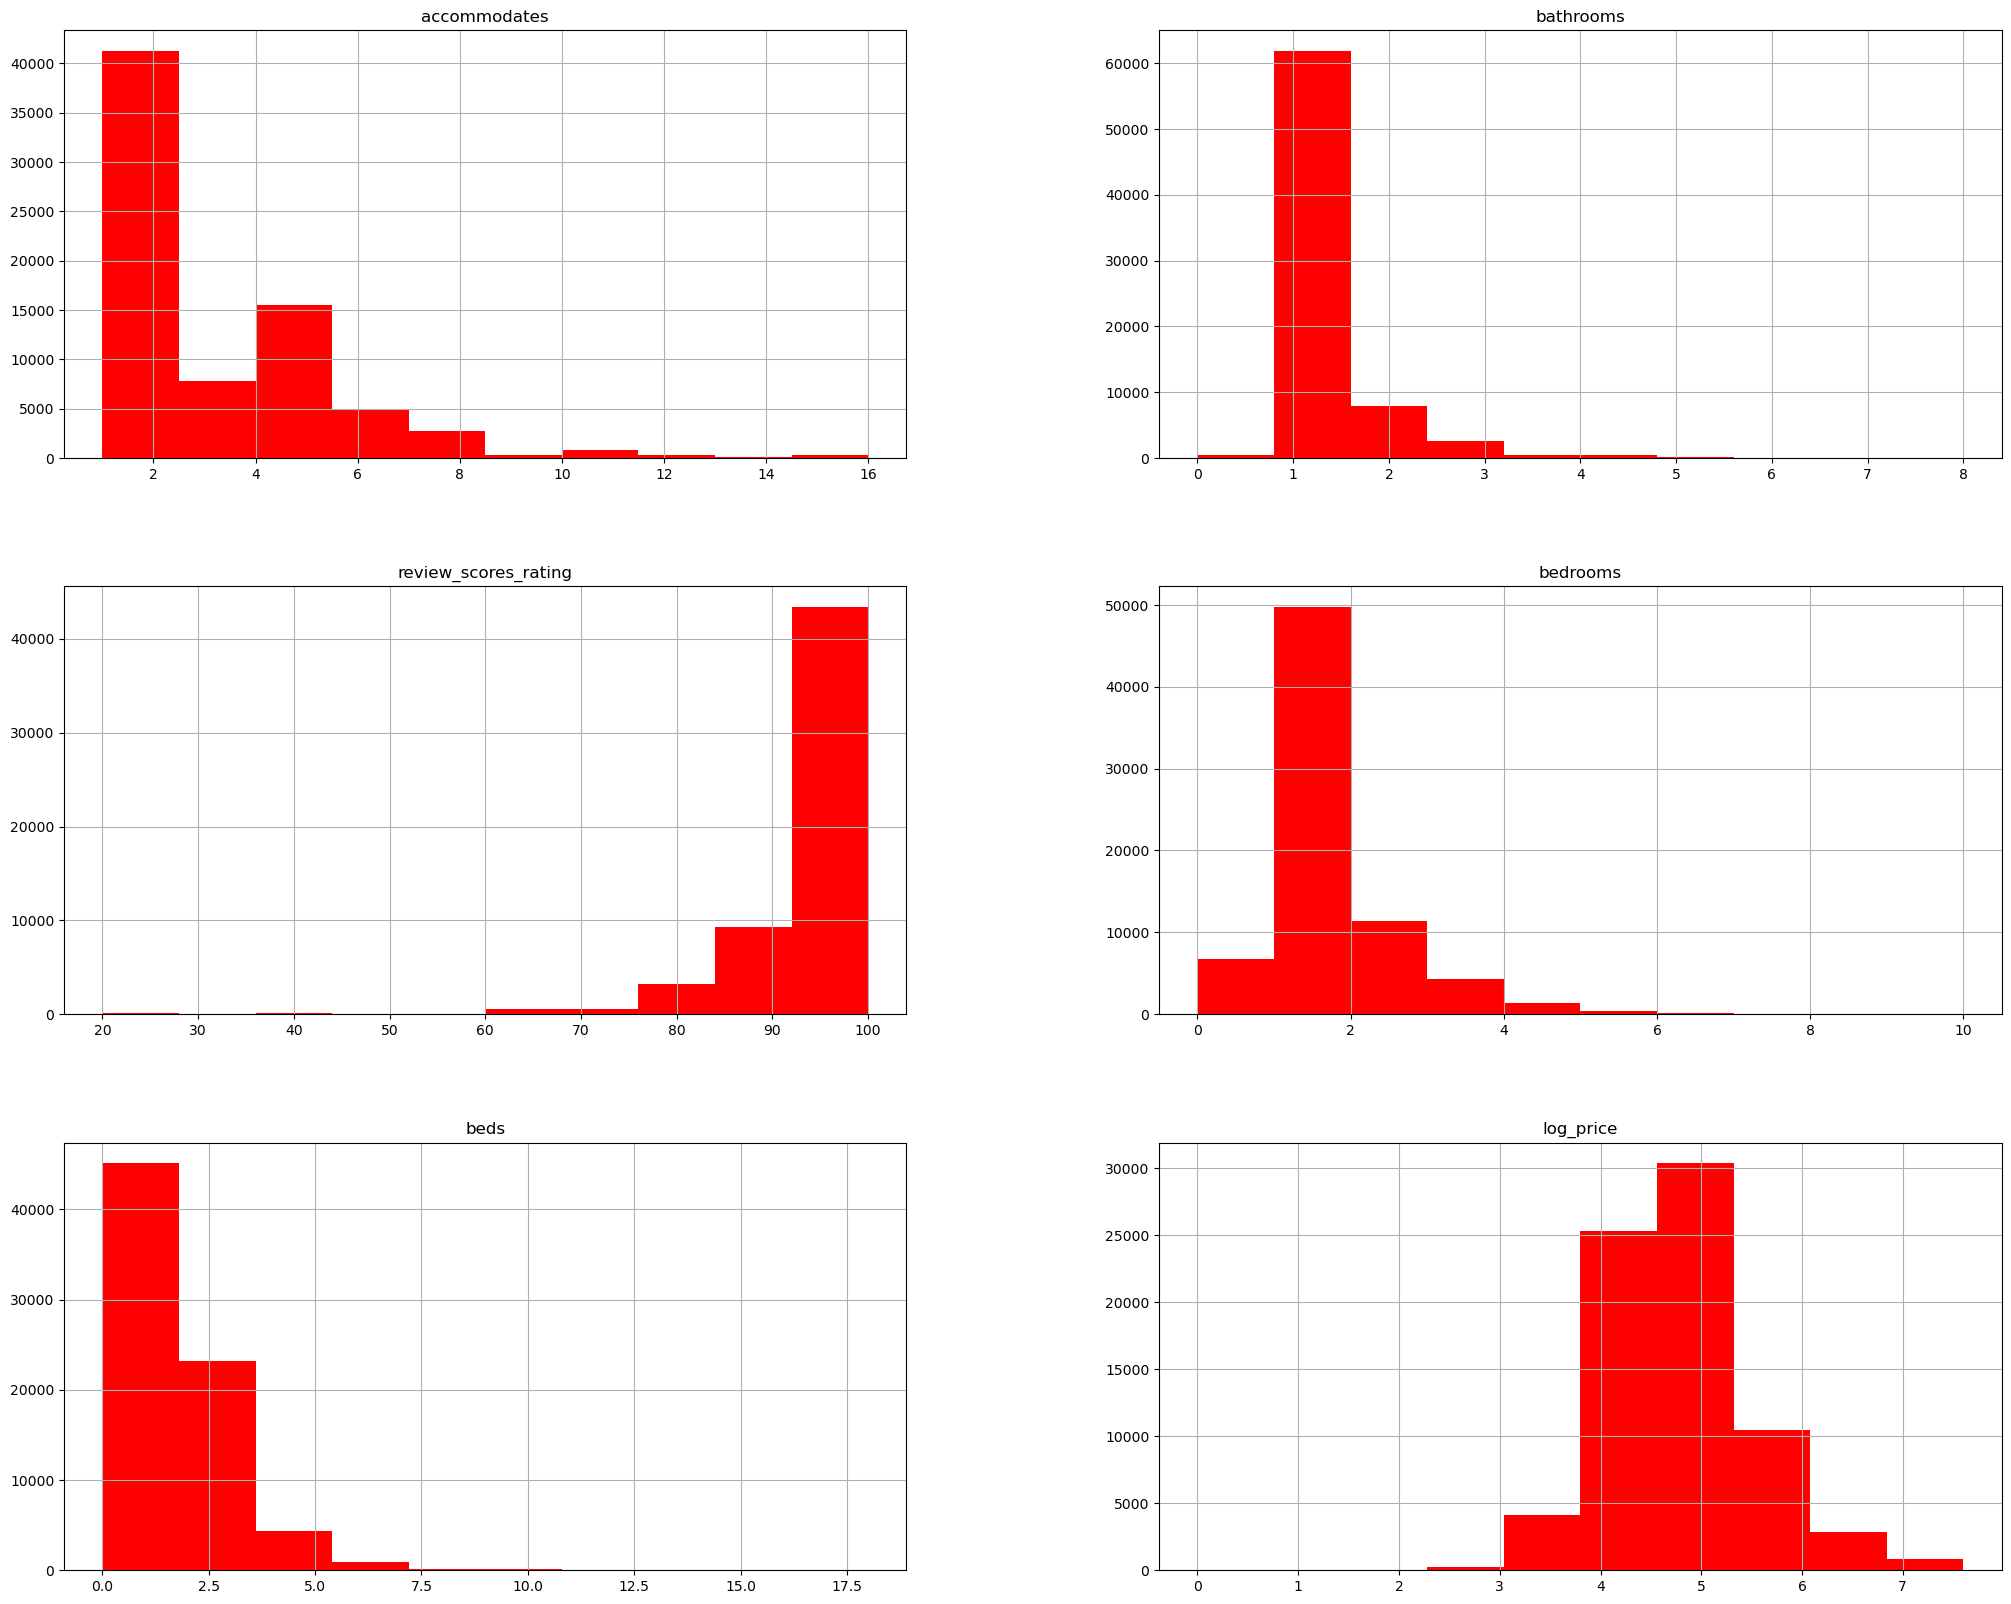

In [11]:
data.hist(figsize=(25,20), color='red');

### Data pre processing

Here we can show the correlation between columns 

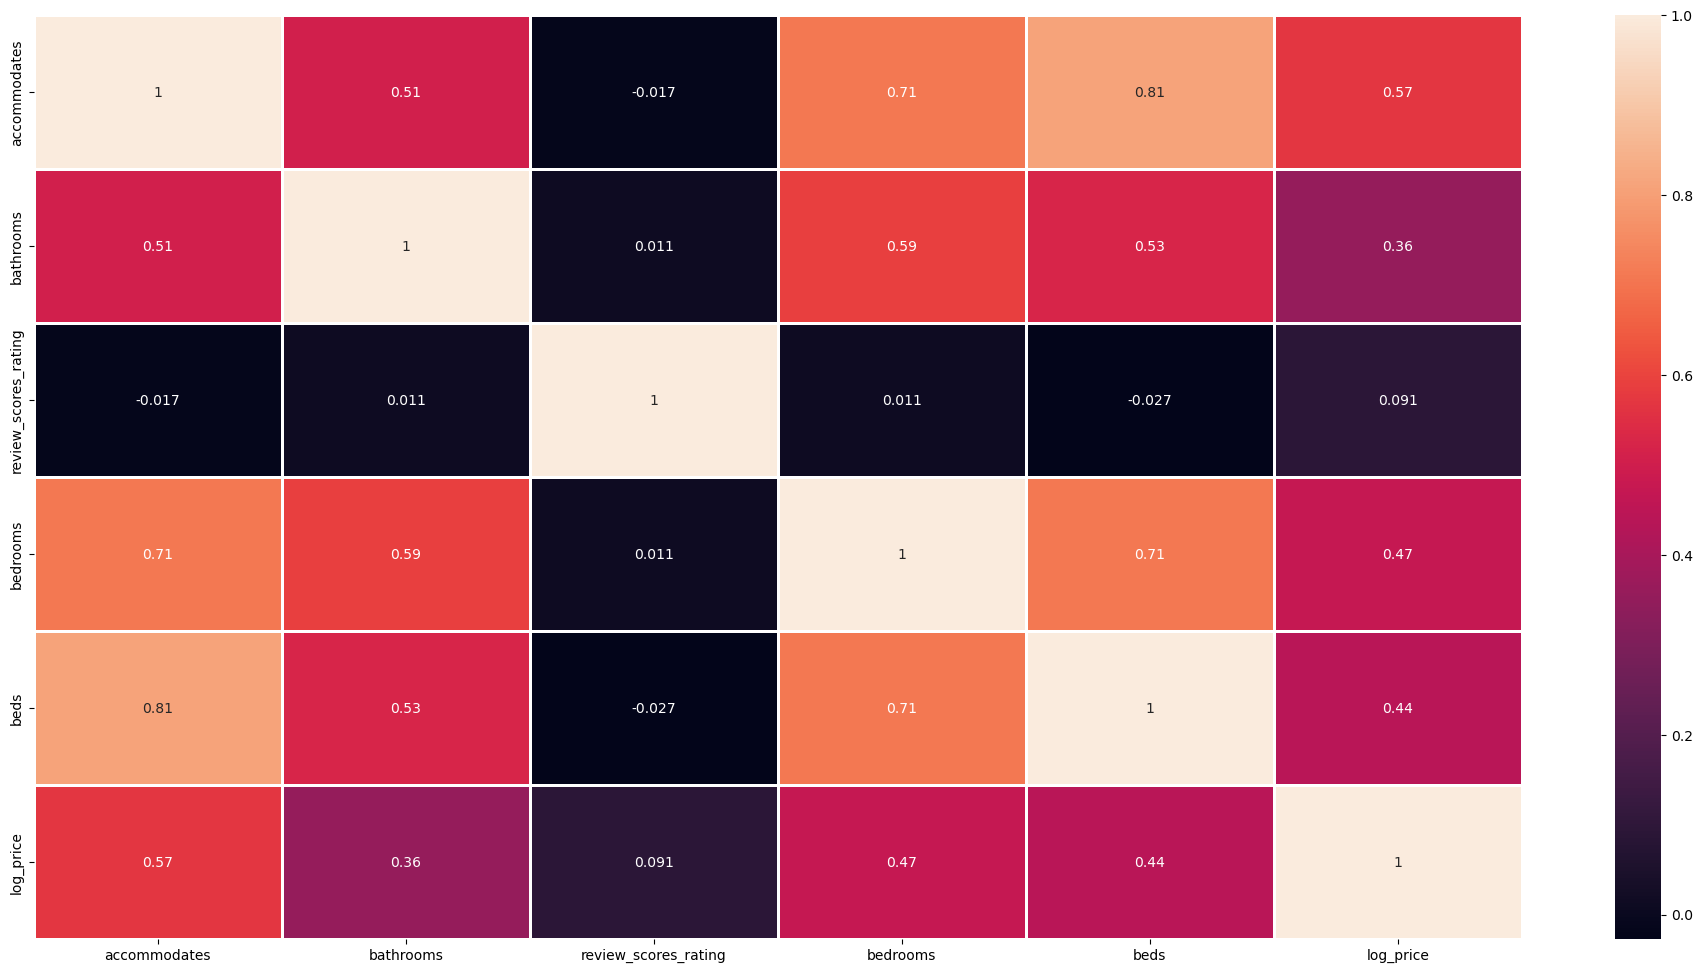

In [12]:
plt.figure(figsize = (24, 12))

corr = data.corr()
sns.heatmap(corr, annot = True, linewidths = 1)
plt.show()

In [13]:
dt = data.copy()

In [14]:
dt['bedrooms_per_accommodates'] = dt['bedrooms'] / dt['accommodates']
dt['beds_per_accommodates'] = dt['beds'] / dt['accommodates']
dt['bathrooms_per_accommodates'] = dt['bathrooms'] / dt['accommodates']

dt[['bedrooms_per_accommodates', 'beds_per_accommodates', 'bathrooms_per_accommodates']].describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms_per_accommodates,74016.000,0.470,0.281,0.000,0.333,0.500,0.500,5.000
beds_per_accommodates,73977.000,0.593,0.292,0.000,0.500,0.500,0.667,16.000
bathrooms_per_accommodates,73908.000,0.509,0.333,0.000,0.333,0.500,0.500,8.000


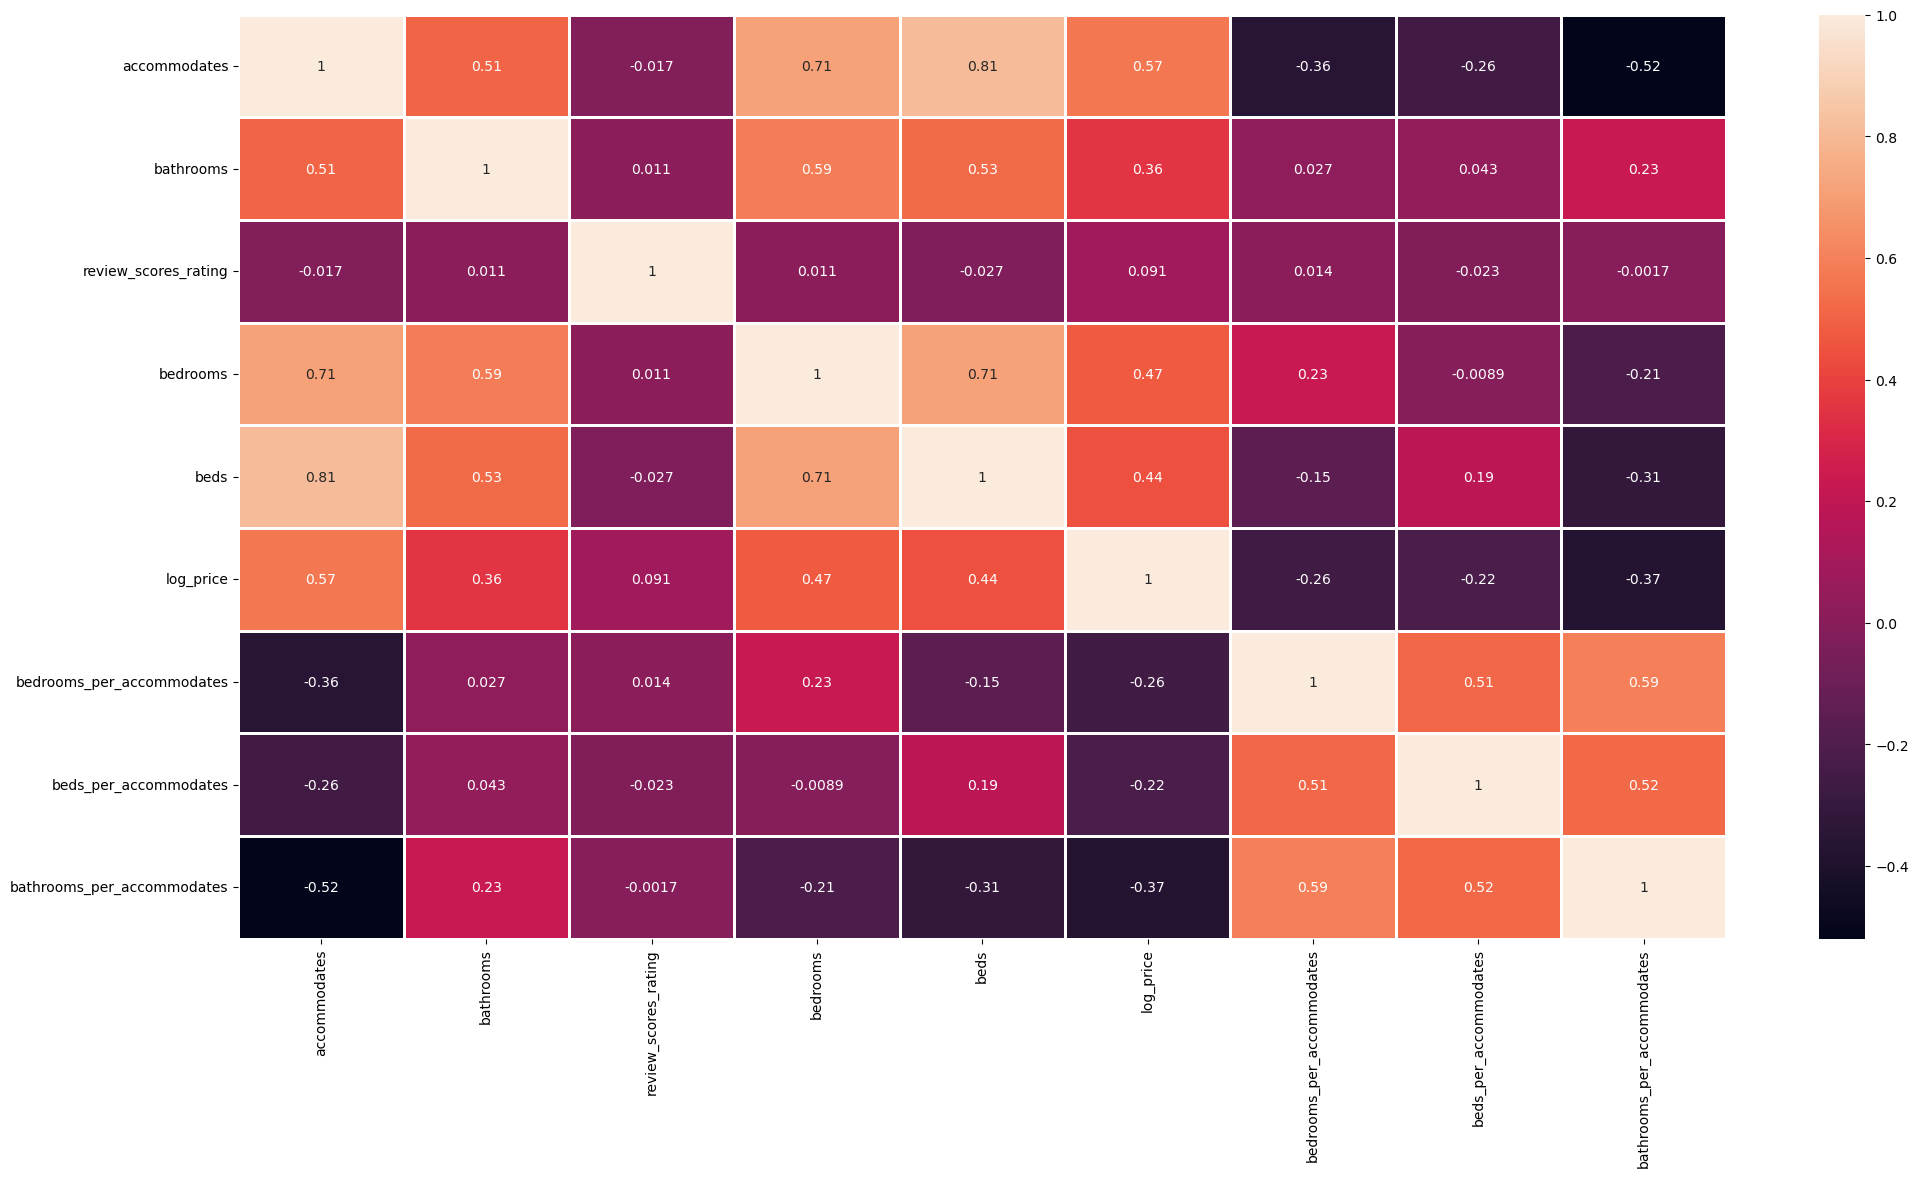

In [15]:
plt.figure(figsize = (24, 12))

corr = dt.corr()
sns.heatmap(corr, annot = True, linewidths = 1)
plt.show()

### Numerical data cleaning

In [16]:
data.fillna(0, inplace = True)

TypeError: Cannot setitem on a Categorical with a new category (0), set the categories first

In [17]:
dataset = data.drop('log_price', axis=1)
data_labels = data['log_price'].copy()
data_num = dataset.drop(['room_type', 'cancellation_policy', 'cleaning_fee', 'instant_bookable'], axis=1)
data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   accommodates          74111 non-null  float64
 1   bathrooms             74111 non-null  float64
 2   review_scores_rating  74111 non-null  float64
 3   bedrooms              74111 non-null  float64
 4   beds                  74111 non-null  float64
dtypes: float64(5)
memory usage: 2.8 MB


In [18]:
data_num.isnull().sum()

accommodates            0
bathrooms               0
review_scores_rating    0
bedrooms                0
beds                    0
dtype: int64

In [20]:
data_num['accommodates'] = np.log(data_num['accommodates'] + 1)
data_num['bathrooms'] = np.log(data_num['bathrooms'] + 1)
data_num['review_scores_rating'] = np.log(data_num['review_scores_rating'] + 1)
data_num['bedrooms'] = np.log(data_num['bedrooms'] + 1)
data_num['beds'] = np.log(data_num['beds'] + 1)

### Categorical data cleaning

In [21]:
data_cat = data[['room_type', 'cancellation_policy', 'cleaning_fee', 'instant_bookable']]
data_cat.head()

,room_type,cancellation_policy,cleaning_fee,instant_bookable
0,Entire home/apt,strict,True,f
1,Entire home/apt,strict,True,t
2,Entire home/apt,moderate,True,t
3,Entire home/apt,flexible,True,f
4,Entire home/apt,moderate,True,t


In [22]:
data_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   room_type            74106 non-null  category
 1   cancellation_policy  74103 non-null  category
 2   cleaning_fee         74107 non-null  category
 3   instant_bookable     74111 non-null  category
dtypes: category(4)
memory usage: 290.1 KB


In [23]:
data_cat.isnull().sum()

room_type              5
cancellation_policy    8
cleaning_fee           4
instant_bookable       0
dtype: int64

In [29]:
data_cat

,room_type,cancellation_policy,cleaning_fee,instant_bookable
0,Entire home/apt,strict,True,f
1,Entire home/apt,strict,True,t
2,Entire home/apt,moderate,True,t
3,Entire home/apt,flexible,True,f
4,Entire home/apt,moderate,True,t
...,...,...,...,...
74106,Private room,flexible,False,f
74107,Entire home/apt,moderate,True,f
74108,Entire home/apt,moderate,True,t
74109,Entire home/apt,strict,True,t


In [32]:
data_cat['room_type'] = data_cat['room_type'].map({'Entire home/apt':0, 'Private room':1, 'Shared room':2})
data_cat['cancellation_policy'] = data_cat['cancellation_policy'].map({'strict':0, 'moderate':1, 'flexible':2})
data_cat['cleaning_fee'] = data_cat['cleaning_fee'].map({True:1, False:0})
data_cat['instant_bookable'] = data_cat['instant_bookable'].map({'t':1, 'f':0})

In [46]:
cat_imputer = SimpleImputer(strategy='mean')
cat_imputer.fit(data_cat)

SimpleImputer()

In [47]:
X_cat = cat_imputer.transform(data_cat)
data_cat = pd.DataFrame(X_cat, columns=data_cat.columns, index=data_cat.index)
data_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   room_type            74111 non-null  float64
 1   cancellation_policy  74111 non-null  float64
 2   cleaning_fee         74111 non-null  float64
 3   instant_bookable     74111 non-null  float64
dtypes: float64(4)
memory usage: 2.3 MB


In [48]:
data_cat.isnull().sum()

room_type              0
cancellation_policy    0
cleaning_fee           0
instant_bookable       0
dtype: int64

### Verify our work

In [49]:
X = pd.concat([data_cat, data_num], axis = 1)
y = data['log_price']
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X)
X = imp.transform(X)

In [50]:
X.shape, y.shape

((74111, 9), (74111,))

### Now we have to split our data

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.50)

## Random forest regression

In [55]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)
y_pred_rf_reg = rf_reg.predict(X_test)

rf_reg.fit(X_train, y_train)
y_pred = rf_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

MSE: 0.2549576796013352


## Linear regression

In [56]:
l_reg = LinearRegression()
l_reg.fit(X_train, y_train)
y_pred_l_reg = l_reg.predict(X_test)

l_reg.fit(X_train, y_train)
y_pred = l_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

MSE: 0.5147927355115242


## Conclusion

The one that I think would work best is **random forest regression**. Since its error is far lower than that of **linear regression**.